In [33]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 10

In [34]:
import csv
import glob
from collections import defaultdict
import pandas as pd
import numpy as np

In [35]:
#From http://rosettacode.org/wiki/Set_consolidation#Python
def consolidate(sets):
    setlist = [set(s) for s in sets if s] # convert to mutable_set
    for i, s1 in enumerate(setlist):
        if s1:
            for s2 in setlist[i+1:]:
                intersection = s1.intersection(s2)
                if intersection:
                    s2.update(s1)
                    s1.clear()
                    s1 = s2
    return [frozenset(s) for s in setlist if s]

In [36]:

def load_paraphrase_groups():
    for filename in glob.glob("opinosis_split/*"):
        table = pd.read_csv(filename, delimiter='\t', header=None,  encoding = "ISO-8859-1")
        
        for col_num in range(1,table.shape[1]): #Skip column zero as that contains unsorted entrys
            pf_group = table.iloc[:,col_num].dropna().tolist()
            if len(pf_group)>0:
                yield pf_group


In [37]:
def postprocess(sentence):
    import re
    def replace_broken_hypen(first_half, second_half, sentence):
        pattern = r"(?<=%s),\s?(?=%s)" % (first_half, second_half)
        return re.sub(pattern, "-",sentence,flags=re.IGNORECASE)
    
    sentence=sentence.strip()
    sentence=re.sub(r"^\d\s(?! hour|out|block)","",sentence,flags=re.IGNORECASE) #remove starting numbers
    sentence=re.sub(r"^([\.\,\-\!\?\;\:\>]\s*)+","",sentence) #remove starting punctuation

    sentence=re.sub(r"(,\s?)+",", ",sentence) #remove repeated commas
    sentence =sentence.replace("&quot", "\"")
    sentence =sentence.replace("&amp", "\"")
   
    sentence =replace_broken_hypen("e", "ink", sentence)
    sentence =replace_broken_hypen("non", "smoking", sentence)
    sentence =replace_broken_hypen("on", "line", sentence)
    return sentence

In [38]:
[frozenset({',  The one thing this hotel has it going for it is the location .',
            'Location is the only thing it has going for it .',
            'Location itself is great, but everything else is terrible .',
            'The single thing to recommend this hotel is the location, which is excellent .'})]

[frozenset({',  The one thing this hotel has it going for it is the location .',
            'Location is the only thing it has going for it .',
            'Location itself is great, but everything else is terrible .',
            'The single thing to recommend this hotel is the location, which is excellent .'})]

In [39]:
pf_groups = list(load_paraphrase_groups())
pf_groups = [frozenset(map(postprocess, group)) for group in pf_groups]
pf_groups = consolidate(pf_groups)

In [51]:
pf_groups = [group for group in pf_groups if len(group)>1]

In [52]:
pf_group_sizes = pd.Series(list(map(len,pf_groups)))
pf_group_sizes.describe()

count    53.000000
mean      7.792453
std       6.642979
min       4.000000
25%       4.000000
50%       6.000000
75%       8.000000
max      33.000000
dtype: float64

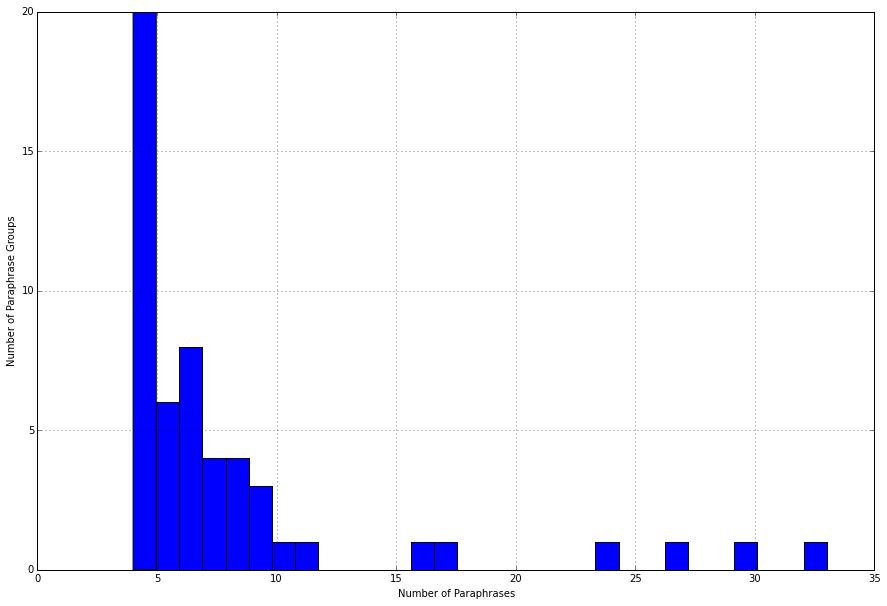

In [53]:
pl.xlabel("Number of Paraphrases")
pl.ylabel("Number of Paraphrase Groups")
plt = pf_group_sizes.hist(bins=30, ax=pl.gca())

In [54]:
pf_groups

[frozenset({"It's 90% size keyboard doesn't take too long to get used to .",
            'Speaking of typing, the keyboard is great, almost full size .',
            "Speaking of which, the keyboard's relatively large size ,  at 92% of the size of a normal one ,  writing longer texts on it is no problem .",
            'The keyboard is large enough to accommodate touch typing with ease .',
            'The keyboard is nearly full size and very comfortable to type on for hours .',
            "The keyboard is only slightly smaller than a regular one, so it's very comfortable .",
            'The keyboard, more than 90% standard size, is just large enough .'}),
 frozenset({"I am 5'10 with large hands and have no problem using the keyboard .",
            "I have large hands and with a little time on the keyboard I'm breezing through word processing jobs .",
            'The keyboard is quite nice and I have very large hands and I make a lot fewer mistakes .',
            'The keyboard is

In [55]:
from os.path import join as pathjoin
import csv

In [56]:
def save(pf_groups, save_dir):
    with open(pathjoin(save_dir,"phrases.txt"),"w") as phrases_fh:
        with open(pathjoin(save_dir,"phrase_groups.csv"),"w") as groups_fh:
            group_csv = csv.writer(groups_fh)
            
            phrase_index = 0;
            for group_index, group in enumerate(pf_groups):
                for phrase in group:
                    phrases_fh.write(phrase)
                    phrases_fh.write("\n")
                    
                    group_csv.writerow([phrase_index,group_index])

                    phrase_index+=1
                

In [46]:
save(pf_groups, "prepared_corpora/opinosis/")